In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torchvision.utils import save_image
from torchvision.transforms.functional import to_grayscale
from PIL import Image
import random

import matplotlib.pyplot as plt
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


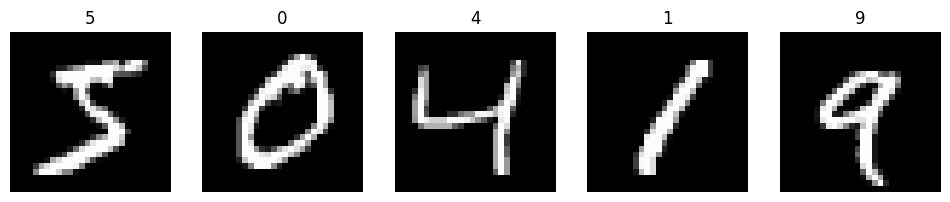

In [3]:

trainset = torchvision.datasets.MNIST(root='./data', train = True, download = True, transform = transforms.ToTensor())
testset = torchvision.datasets.MNIST(root='./data', train = False, download = True, transform = transforms.ToTensor())
xtrain = trainset.data.numpy()
ytrain = trainset.targets.numpy()
x_val = testset.data[:1000].numpy()
y_val = testset.targets[:1000].numpy()


def plot_images(images, labels, num_images=5):
    _, axes = plt.subplots(1, num_images, figsize=(12, 3))
    for i in range(num_images):
        axes[i].imshow(images[i], cmap='gray')
        axes[i].set_title(labels[i])
        axes[i].axis('off')
    plt.show()

plot_images(xtrain, ytrain)

In [4]:
count = np.zeros(10)
idx = []
for i in range(0, len(ytrain)):
  for j in range(10):
    if(ytrain[i] == j):
      count[j] += 1
      if(count[j]<=2000):
        idx = np.append(idx, i)
        
ytrain = ytrain[idx.astype('int')]
xtrain = xtrain[idx.astype('int')]

In [5]:
xtrain = np.where(xtrain > 128, 1, 0)
x_val = np.where(x_val > 128, 1, 0)
xtrain = xtrain.astype(np.float32)
x_val = x_val.astype(np.float32)

In [6]:
batch_size = 32
trainloader = torch.utils.data.DataLoader([[xtrain[i], ytrain[i]] for i in range(len(ytrain))], shuffle=True, batch_size=batch_size)
testloader = torch.utils.data.DataLoader([[x_val[i], y_val[i]] for i in range(len(y_val))], shuffle=True, batch_size=100)
     

In [7]:
import torch
import torch.nn as nn

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, 128)  # Encoder
        self.fc2 = nn.Linear(128, 16)   # Encoder
        self.fc21 = nn.Linear(16, 8)    # mu
        self.fc22 = nn.Linear(16, 8)    # sigma

        self.fc3 = nn.Linear(8, 16)    # Decoder
        self.fc4 = nn.Linear(16, 128)  # Decoder
        self.fc5 = nn.Linear(128, 784)

    def encoder(self, x):
        h = nn.ReLU()(self.fc2(nn.ReLU()(self.fc1(x))))
        return self.fc21(h), self.fc22(h)  # mu, std

    def sampling(self, mu, std):  # Reparameterization trick
        eps1 = torch.randn_like(std)
        eps2 = torch.randn_like(std)
        return 0.5 * ((eps1 * std + mu) + (eps2 * std + mu))  # z

    def decoder(self, z):
        h = nn.ReLU()(self.fc4(nn.ReLU()(self.fc3(z))))
        return torch.sigmoid(self.fc5(h))

    def forward(self, x):
        mu, std = self.encoder(x.view(-1, 784))
        z = self.sampling(mu, std)
        return self.decoder(z), mu, std

model = VAE()
if torch.cuda.is_available():
    model.cuda()


In [8]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.002)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', factor=0.5, 
                             patience=5, threshold=0.001, cooldown=0,
                             min_lr=0.0001, verbose=True)

def loss_function(y, x, mu, std): 
    ERR = F.binary_cross_entropy(y, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + torch.log(std**2) - mu**2 - std**2)
    return ERR + KLD
     

In [9]:
count=0
loss_record, test_loss_record = [], []
for epoch in range(1, 100):
    
    train_loss = 0
    for batch_idx, (data, _) in enumerate(trainloader):
        model.train()
        data = data.cuda()
        bsize = data.shape[0]
        recon_batch, mu, std = model(data)
        loss= loss_function(recon_batch, data, mu, std)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()

    scheduler.step(train_loss / len(trainloader.dataset))
    loss_record.append(train_loss / len(trainloader.dataset))
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(trainloader.dataset)))
    model.eval()
    test_loss= 0
    with torch.no_grad():
        for data, _ in testloader:
            data = data.cuda()
            recon, mu, std = model(data)
            loss = loss_function(recon, data, mu, std)
            test_loss += loss.item()
    
    test_loss /= len(testloader.dataset)
    test_loss_record.append(test_loss)
    
    print('====> Test set loss: {:.4f}'.format(test_loss))

====> Epoch: 1 Average loss: 196.4413
====> Test set loss: 161.9929
====> Epoch: 2 Average loss: 155.9882
====> Test set loss: 145.2347
====> Epoch: 3 Average loss: 142.7734
====> Test set loss: 137.7745
====> Epoch: 4 Average loss: 135.2836
====> Test set loss: 131.6006
====> Epoch: 5 Average loss: 129.5630
====> Test set loss: 127.7913
====> Epoch: 6 Average loss: 126.8350
====> Test set loss: 125.7517
Epoch 00007: reducing learning rate of group 0 to 1.0000e-03.
====> Epoch: 7 Average loss: 123.5183
====> Test set loss: 122.5809
====> Epoch: 8 Average loss: 119.8293
====> Test set loss: 120.1648
====> Epoch: 9 Average loss: 118.5928
====> Test set loss: 119.1021
====> Epoch: 10 Average loss: 117.6126
====> Test set loss: 119.0567
====> Epoch: 11 Average loss: 116.7657
====> Test set loss: 117.7602
====> Epoch: 12 Average loss: 116.0729
====> Test set loss: 117.2260
Epoch 00013: reducing learning rate of group 0 to 5.0000e-04.
====> Epoch: 13 Average loss: 115.3872
====> Test set los

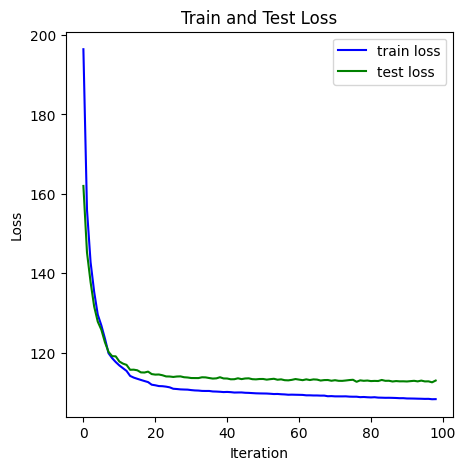

In [80]:
plt.figure(figsize=(5, 5))

# Plotting both train and test loss on the same graph
plt.plot(loss_record, 'b', label='train loss')
plt.plot(test_loss_record, 'g', label='test loss')

plt.title('Train and Test Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()

In [12]:
def generate_num():
    num = random.randint(1,1000)
    print(testset[num][1])
    input_pic = testset[num][0].to(device).view(-1)
    
    
    mu, std = model.encoder(input_pic)
    z = model.sampling(mu, std)
    return z

In [73]:
generate1 = generate_num()
generate2 = generate_num()
generate3 = generate_num()
generate4 = generate_num()

4
6
5
7


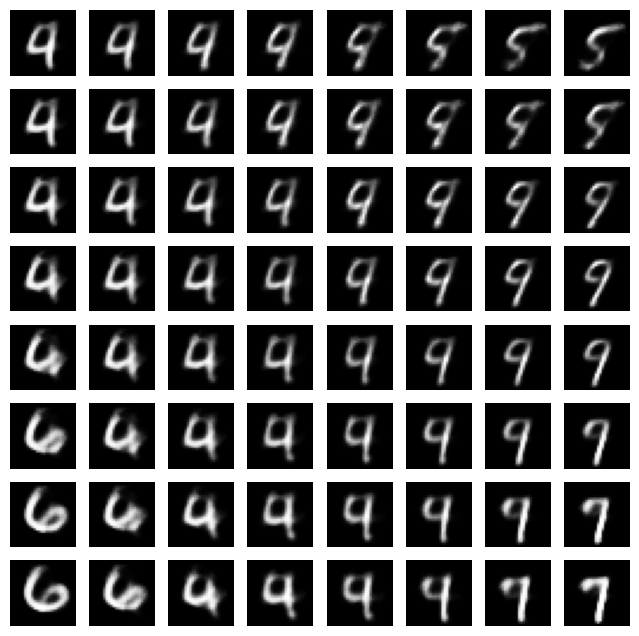

In [74]:
fig, axs = plt.subplots(8, 8, figsize=(8, 8))
for i in range(8):
    for j in range(8):
        # Calculate the interpolation between generate1 and generate2
        gap1 = (generate2 - generate1) / 7
        next1 = generate1 + gap1 * i

        # Calculate the interpolation between generate3 and generate4
        gap2 = (generate4 - generate3) / 7
        next2 = generate3 + gap2 * i

        # Calculate the final interpolation between next1 and next2
        final_gap = (next2 - next1) / 7
        final_result = next1 + final_gap * j

        # Generate image using the decoder
        produce = model.decoder(final_result)
        result = produce.reshape((28, 28)).detach().cpu()

        # Plot the image
        axs[i, j].imshow(result, cmap='gray')
        axs[i, j].axis('off')

plt.show()
